In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
import h5py
import os
import csv

RGBs = ['r', 'g', 'b']

In [2]:
from ImgProcess import *     # import all functions from ../Codes/ImgProcessing.py
from KSVD import *              # import all functions from ../Codes/KSVD.py

In [3]:
def DiceLearn(img, size, sparsity, max_iter=10, overlapping=2, mD=None):
    patches, locs, dcs = Img2patch(img, size, overlapping)
    if mD is None:
        mD = fft.dct(np.eye(2 * size**2), norm='ortho')[: size**2]  # initial dictionary
    mD, mX = KSVD(patches, mD, sparsity, max_iter)              # learn the dictionary
    img_learned = Img2patch(mD@mX, locs, dcs, inv=True)         # reconstruct the image
    return img_learned, mD


def MSR(img, img_denoised):
    return np.sum((img - img_denoised)**2) / img.size


def PSNR(img, img_denoised):
    return 10 * np.log10(1 / MSR(img, img_denoised))


with open('../results/PSNR.csv', 'w', newline='') as f_psnr:
    writer = csv.writer(f_psnr)
    writer.writerow(['image', 'r', 'g', 'b'])

# Task 1. 灰色图像的字典学习算法

使用 K-SVD 算法对灰度图像进行字典学习. 

In [4]:
# read the gray scale images
path = '../Images/'
imgs_gray = {}
for file in [file for file in os.listdir(path) if file.endswith('.png')]:
    imgs_gray[file] = plt.imread(path + file)

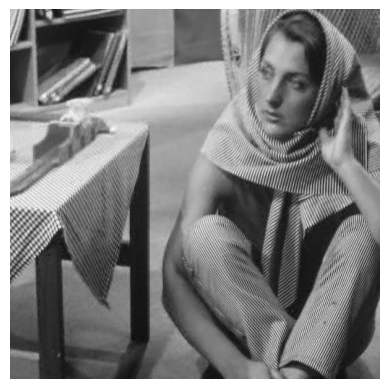

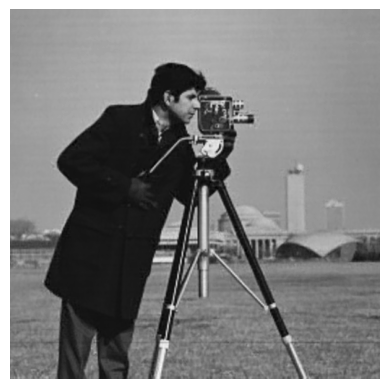

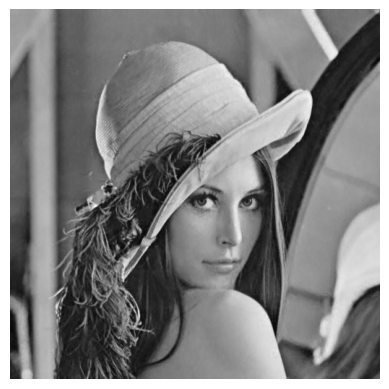

In [5]:
for img_name in list(imgs_gray.keys()):
    img = imgs_gray[img_name]
    size = 16
    img_learned, mD = DiceLearn(img, size, 8, 10)
    
    path_dict = '../results/dictionaries/' + img_name[:-4] + '.csv'
    with open(path_dict, 'w', newline='') as f_dict:
        writer = csv.writer(f_dict)
        writer.writerow([img_name, f'patch size = {size}'])
        writer.writerows(mD)
        writer.writerow([''])
    
    Show(img_learned)

# Task 2&3. 彩色图像的字典学习算法与降噪

In [6]:
path = '../Images/McM images/'
# read the color images
imgs_clear = {}
for file in [file for file in os.listdir(path) if file.endswith('.tif')]:
    _img = plt.imread(path + file)    # extract the color channels
    imgs_clear[file] = [_img[:,:,0], _img[:,:,1], _img[:,:,2]]

# read the noisy color images
imgs_noise = {}
for file in [file for file in os.listdir(path) if file.endswith('.mat')]:
    _img = h5py.File(path + file)    # extract the color channels
    imgs_noise[file] = [_.T for _ in _img['u_n']]

In [7]:
for img_name in list(imgs_clear.keys()):
    # load the image
    img = imgs_clear[img_name]
    img_noise = imgs_noise[img_name[:-4] + '_noise.mat']

    size = 16

    # learn the dictionary for each channel
    img_learned = []
    dicts = {}
    for i, color in enumerate(RGBs):
        channel = img[i]
        channel_learned, mD = DiceLearn(channel, size, 8, 10)

        img_learned.append(channel_learned)
        dicts[color] = mD   # record the learned dictionary

    # save the learned dictionary
    path_dict = '../results/dictionaries/' + img_name[:-4] + '.csv'
    with open(path_dict, 'w', newline='') as f_dict:
        writer = csv.writer(f_dict)
        writer.writerow([img_name, f'patch size = {size}']) # write the image name and patch size
        for color in RGBs:
            writer.writerow(['channel:' + color])           # write the channel name
            writer.writerows(dicts[color])                  # write the dictionary
            writer.writerow([''])

    # denoise the image using the learned dictionary
    img_denoised = []
    for i, color in enumerate(RGBs):
        # extract the channel
        mD = dicts[color]
        channel_noise = img_noise[i]

        # denoise the channel: use max_iter=1 only learning once for the sparse coding
        channel_denoised, _ = DiceLearn(channel_noise, size, 4, max_iter=1, mD=mD)
        # normalize the channel
        channel_denoised = (channel_denoised - channel_denoised.min()) / (channel_denoised.max() - channel_denoised.min())
        
        img_denoised.append(channel_denoised)

    # save the denoised image
    path_img = '../results/images denoised/' + img_name[:-4] + '.png'
    plt.imsave(path_img, np.stack(img_denoised, axis=2))

    # calculate the PSNR value
    psnr = {}
    for i, color in enumerate(RGBs):
        channel = img[i] / 255
        channel_denoised = img_denoised[i]
        psnr[color] = PSNR(channel, channel_denoised)

    # write the PSNR value to the csv file
    with open('../results/PSNR.csv', 'a', newline='') as f_psnr:
        writer = csv.writer(f_psnr)
        writer.writerow([img_name[: -4], psnr['r'], psnr['g'], psnr['b']])